# PART - ONE

<b>DOMAIN: </b> Botanical research

<b> CONTEXT: </b> University X is currently undergoing some research involving understanding the characteristics of plant and plant seedlings at various stages of growth. They already have have invested on curating sample
images. They require an automation which can create a classifier capable of determining a plant's species from a photo

<b> DATA DESCRIPTION: </b> The dataset comprises of images from 12 plant species. Source: https://www.kaggle.com/c/plant-seedlings-classification/data

<b> PROJECT OBJECTIVE: </b> University’s management require an automation which can create a classifier capable of determining a plant's species from a photo

<b> Steps and tasks: </b>

1. Import the data. Analyse the dimensions of the data. Visualise the data

In [56]:
# imports
import warnings
warnings.filterwarnings("ignore")

import os
from os import listdir
from google.colab import drive


import numpy as np
import pandas as pd

# from statistics import mean
import math

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV

import seaborn as sns
import matplotlib.pyplot as plt 

import pickle

#to handle images
from PIL import Image
import cv2

#Sklearn
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import RandomizedSearchCV,StratifiedKFold

# %tensorflow_version 2.x
import tensorflow
tensorflow.__version__

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Activation, InputLayer
from tensorflow.keras import regularizers #for l2 regularization
from tensorflow.keras.optimizers import Adam   #for adam optimizer
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier 
from tensorflow.keras import backend as bk
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

In [3]:
drive.mount('/content/drive')

# input location to read from
input_loc = '/content/drive/MyDrive/Part-1 - Plant Seedling Classification Data/train/'


# declare y labels for classes
y_label = {'Black-grass'                :'0',
           'Charlock'                   :'1' ,
           'Cleavers'                   :'2',
           'Common Chickweed'           :'3',
           'Common wheat'               :'4',
           'Fat Hen'                    :'5',
           'Loose Silky-bent'           :'6',
           'Maize'                      :'7',
           'Scentless Mayweed'          :'8',
           'Shepherds Purse'            :'9',
           'Small-flowered Cranesbill'  :'10',
           'Sugar beet'                 :'11'
           }

Mounted at /content/drive


In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Jan  2 11:01:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [74]:
#read all input files in a folder
#flatten the data and give y label
#concat to create a single dataset

def get_img(data_path):
    # Getting image array from path:
    print("Reading...",data_path)
    size_im = 128
    size = (size_im,size_im) #standardize size as pics are of various sizes
    im = Image.open(data_path)
    im1=im.resize(size)
    im_mat  = np.array(im1) # convert to image data to 3-d matrix
    im_shape = im_mat.shape
    print("Shape of ",data_path,": ",im_shape)

    # check if image has alpha
    if im_shape[2] > 3:
      print("im mode:",im1.mode)
      im1 = remove_transparency(im1)
      im_mat  = np.array(im1) # convert to image data to 3-d matrix
      im_shape = im_mat.shape
      print("**************************")
      print("Shape of ",data_path,"after remove transparency: ",im_shape)
      print("**************************")

    if (im_shape[0]<size_im) or (im_shape[1] < size_im): # if shape less than cut off
      print("**************************")
      print("Shape less than cutoff for: ",data_path)
      print("**************************")
    # img_flatten=np.array(im_mat).reshape((im_shape[0], im_shape[1]*im_shape[2])) 
    # return img_flatten
    return im_mat

def remove_transparency(im, bg_colour=(255, 255, 255)):

    # Only process if image has transparency (http://stackoverflow.com/a/1963146)
    if im.mode in ('RGBA', 'LA') or (im.mode == 'P' and 'transparency' in im.info):

        # Create a new background image
        bg = Image.new("RGB", im.size, (255, 255, 255))
        bg.paste(im, mask= im.split()[3])
        return bg

    
def get_dataset(dataset_path=input_loc):
  
   #Reads all input images, resizes the images and saves the images as numpy data
   
   
    try:
        os.chdir('/content/drive/MyDrive/Colab Notebooks/') #change cwd
        X = np.load('npy_dataset/X.npy')
        Y = np.load('npy_dataset/Y.npy')
    except:
        labels = listdir(dataset_path) # Getting labels
        X = []
        Y = []
       
        for label in labels:
            datas_path = dataset_path+'/'+label
            for data in listdir(datas_path):
                
                img = get_img(datas_path+'/'+ data)
                X.append(img)
                Y.append(int(y_label[label])) # convert to corresponding y_label
        print(type(X))
        print(X[0].shape,X[1].shape)
        print(type(X[0]))

        # Create dataset:
        X = np.array(X).astype('float32')/255 #convert list to array and standardize
        print("size of X:",X.nbytes)
        # X = np.array(X/255) #standardize X  
        Y = np.array(Y).astype('float32')
        # Y = to_categorical(Y) #create categorical Y
        
        os.chdir('/content/drive/MyDrive/Colab Notebooks/') #change cwd
        if not os.path.exists('npy_dataset/'):
            os.makedirs('npy_dataset/') #create new folder
        np.save('npy_dataset/X.npy', X) #save input data
        np.save('npy_dataset/Y.npy', Y) #save class labels

    
    return X, Y

In [6]:
X,Y = get_dataset()

Streaming output truncated to the last 5000 lines.
Reading... /content/drive/MyDrive/Part-1 - Plant Seedling Classification Data/train//Loose Silky-bent/1f57bde3c.png
Shape of  /content/drive/MyDrive/Part-1 - Plant Seedling Classification Data/train//Loose Silky-bent/1f57bde3c.png :  (128, 128, 3)
Reading... /content/drive/MyDrive/Part-1 - Plant Seedling Classification Data/train//Loose Silky-bent/2399027ab.png
Shape of  /content/drive/MyDrive/Part-1 - Plant Seedling Classification Data/train//Loose Silky-bent/2399027ab.png :  (128, 128, 3)
Reading... /content/drive/MyDrive/Part-1 - Plant Seedling Classification Data/train//Loose Silky-bent/1dc7d9cc4.png
Shape of  /content/drive/MyDrive/Part-1 - Plant Seedling Classification Data/train//Loose Silky-bent/1dc7d9cc4.png :  (128, 128, 3)
Reading... /content/drive/MyDrive/Part-1 - Plant Seedling Classification Data/train//Loose Silky-bent/1f8562553.png
Shape of  /content/drive/MyDrive/Part-1 - Plant Seedling Classification Data/train//Loose

In [7]:
(unique, counts) = np.unique(Y, return_counts=True)
frequencies = np.asarray((unique, counts)).T

print(frequencies)

[[  0. 263.]
 [  1. 390.]
 [  2. 287.]
 [  3. 611.]
 [  4. 221.]
 [  5. 475.]
 [  6. 671.]
 [  7. 221.]
 [  8. 516.]
 [  9. 231.]
 [ 10. 496.]
 [ 11. 385.]]


<b> There is class imbalance in the data - more training images for 'Common Chickweed' , 'Loose Silky-bent', 'Scentless Mayweed' </b>

In [8]:
X.max(), X.min(),X.shape

(1.0, 0.0, (4767, 128, 128, 3))

In [11]:
xs_train, xs_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, stratify = Y, random_state=10) #split train and test datasets
print(f"#### Shapes of Train, Test sets are: {xs_train.shape},{xs_test.shape}")

#### Shapes of Train, Test sets are: (3336, 128, 128, 3),(1431, 128, 128, 3)


In [12]:
(unique, counts) = np.unique(y_train, return_counts=True)
frequencies = np.asarray((unique, counts)).T

print(frequencies)

[[  0. 184.]
 [  1. 273.]
 [  2. 201.]
 [  3. 428.]
 [  4. 155.]
 [  5. 332.]
 [  6. 469.]
 [  7. 155.]
 [  8. 361.]
 [  9. 162.]
 [ 10. 347.]
 [ 11. 269.]]


In [13]:
(unique, counts) = np.unique(y_test, return_counts=True)
frequencies = np.asarray((unique, counts)).T

print(frequencies)


[[  0.  79.]
 [  1. 117.]
 [  2.  86.]
 [  3. 183.]
 [  4.  66.]
 [  5. 143.]
 [  6. 202.]
 [  7.  66.]
 [  8. 155.]
 [  9.  69.]
 [ 10. 149.]
 [ 11. 116.]]


<b> Train and test in similar proportions </b>

In [131]:
labels = listdir(input_loc) # Getting labels
plot_x=[]
for label in labels:
  datas_path = input_loc+'/'+label
  counter=0
  for data in listdir(datas_path):
      if counter >=5: # get only top 5 pics for display
        break
      img = get_img(datas_path+'/'+ data)
      plot_x.append(img)
      counter+=1
print(len(plot_x))     

Reading... /content/drive/MyDrive/Part-1 - Plant Seedling Classification Data/train//Black-grass/0050f38b3.png
Shape of  /content/drive/MyDrive/Part-1 - Plant Seedling Classification Data/train//Black-grass/0050f38b3.png :  (128, 128, 3)
Reading... /content/drive/MyDrive/Part-1 - Plant Seedling Classification Data/train//Black-grass/05eedce4d.png
Shape of  /content/drive/MyDrive/Part-1 - Plant Seedling Classification Data/train//Black-grass/05eedce4d.png :  (128, 128, 3)
Reading... /content/drive/MyDrive/Part-1 - Plant Seedling Classification Data/train//Black-grass/0260cffa8.png
Shape of  /content/drive/MyDrive/Part-1 - Plant Seedling Classification Data/train//Black-grass/0260cffa8.png :  (128, 128, 3)
Reading... /content/drive/MyDrive/Part-1 - Plant Seedling Classification Data/train//Black-grass/0183fdf68.png
Shape of  /content/drive/MyDrive/Part-1 - Plant Seedling Classification Data/train//Black-grass/0183fdf68.png :  (128, 128, 3)
Reading... /content/drive/MyDrive/Part-1 - Plant

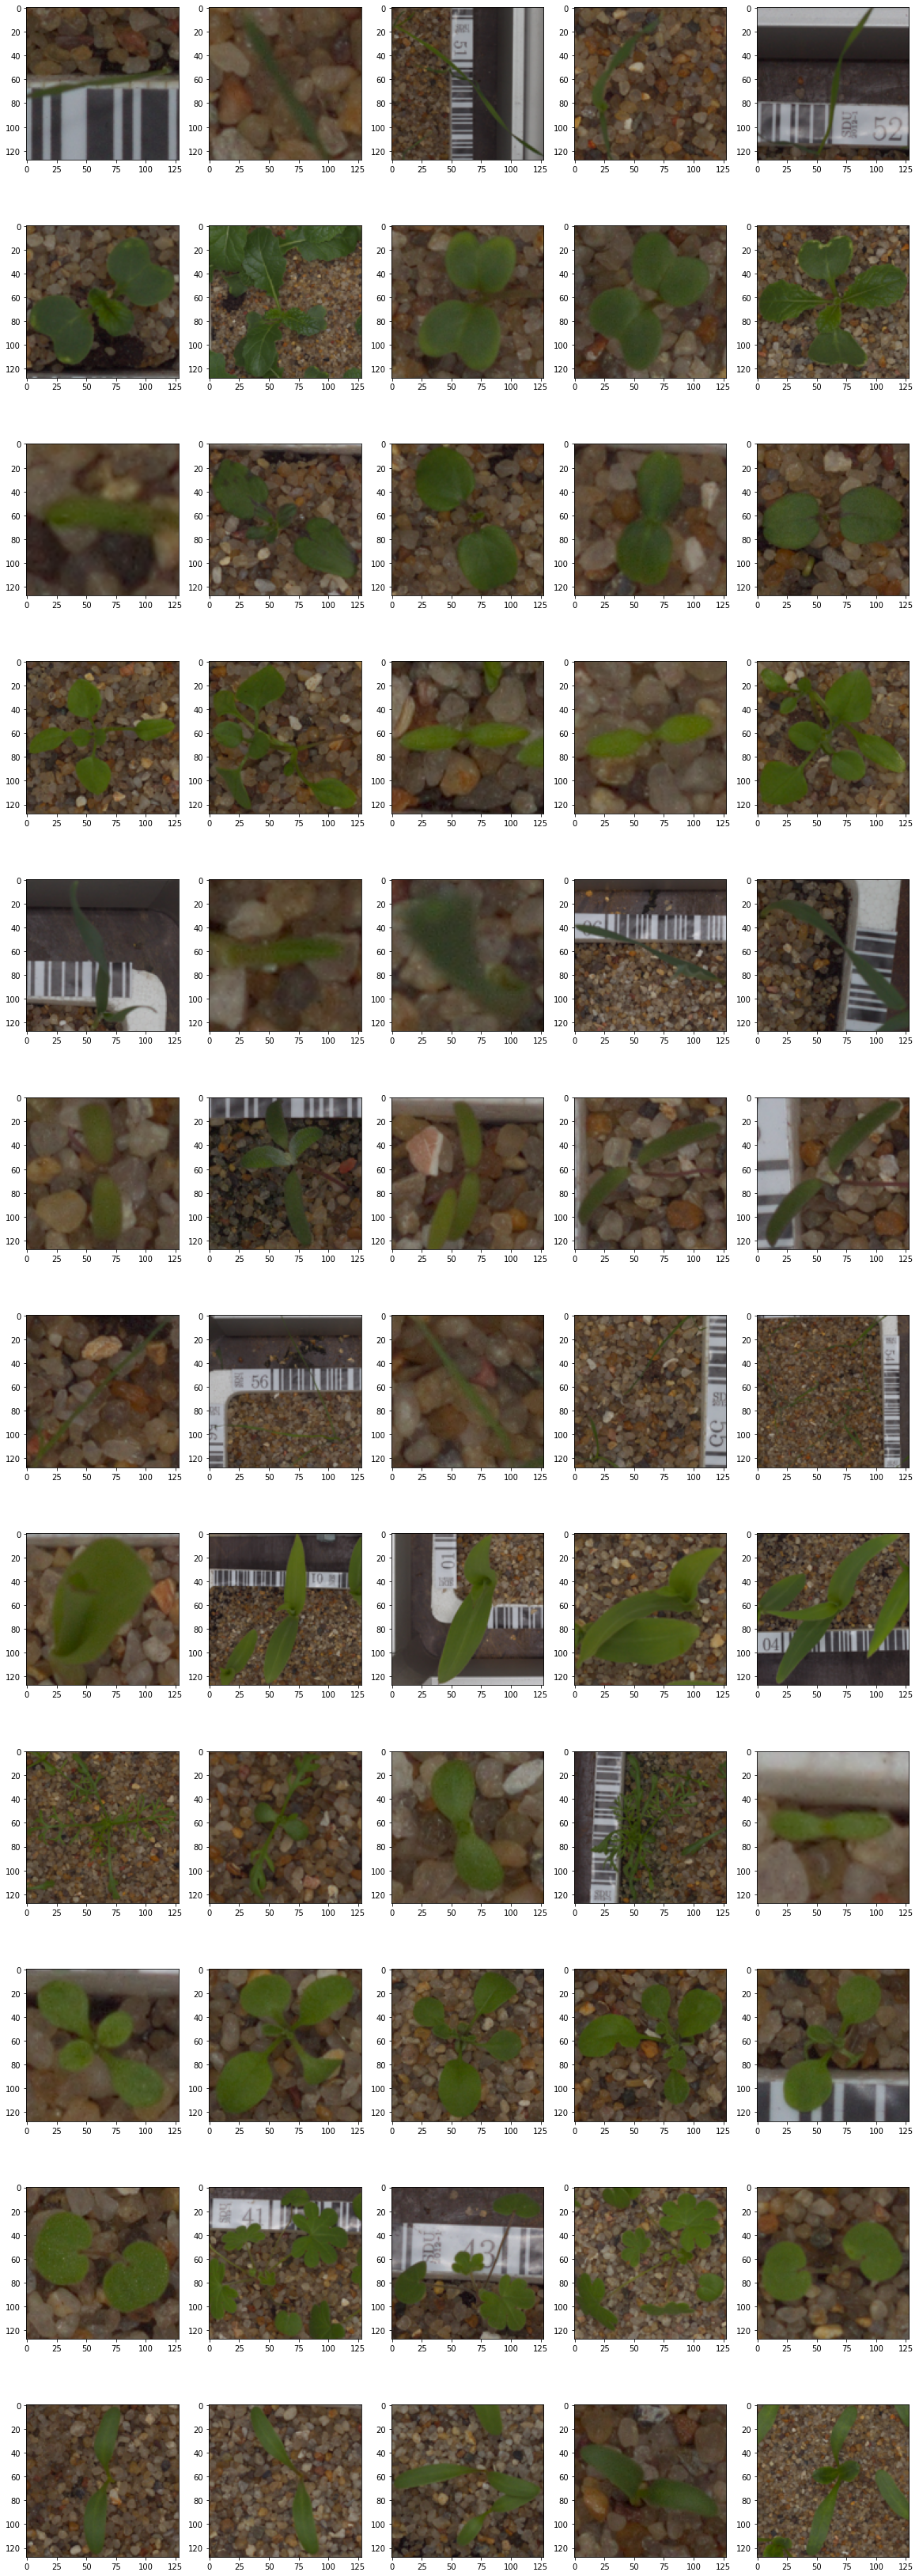

In [148]:
fig, axs = plt.subplots(12,5,figsize=(20,60))
row=0
position = 0
# set position of subplot using mod operator
for i in range(0,60): 

  # set position of subplot using mod operator
    position = (i+1) % 5
    if  position == 0:
        position = 5 # if 4th position, mod will be 0. Set it to 5.

    # set row of subplot using i
    if ((i+1)%5==1) and i!=0 :
        row = row+1
    ax = axs[row,position-1]
    ax.imshow(plot_x[i])
    # plt.tight_layout()
plt.show() 

In [14]:
# use PCA to reduce dimensions. 

def split_colour(x):
  Xr, Xg, Xb = [],[],[] # initialize
  for samples in x:
    r, g, b = cv2.split(samples)
    Xr.append(r.flatten())
    Xg.append(g.flatten())
    Xb.append(b.flatten())
  Xr = np.array(Xr)
  Xg = np.array(Xg)
  Xb = np.array(Xb)
  return (Xr, Xg, Xb)

X_train_r, X_train_g, X_train_b = split_colour(xs_train) # split to do pca
X_test_r, X_test_g, X_test_b = split_colour(xs_test) # split to do pca


In [15]:
X_train_r.shape, X_train_g.shape, X_train_b.shape,X_test_r.shape, X_test_g.shape, X_test_b.shape # check shapes

((3336, 16384),
 (3336, 16384),
 (3336, 16384),
 (1431, 16384),
 (1431, 16384),
 (1431, 16384))

[1.1620869e-01 5.1069859e-02 4.9943160e-02 ... 3.8999498e-19 1.9976648e-19
 1.7931699e-19]


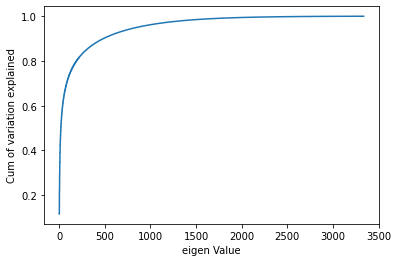

In [16]:
#calculate PCA for every channel
pca_r = PCA(n_components=min(X_train_r.shape[1],X_train_r.shape[0])) # minimum of rows or columns
pca_g = PCA(n_components=min(X_train_g.shape[1],X_train_g.shape[0])) # minimum of rows or columns
pca_b = PCA(n_components=min(X_train_b.shape[1],X_train_b.shape[0])) # minimum of rows or columns

X_train_pca_r = pca_r.fit_transform(X_train_r) # pca for r channel
X_train_pca_g = pca_g.fit_transform(X_train_g) # pca for g channel
X_train_pca_b = pca_b.fit_transform(X_train_b) # pca for b channel

print(pca_r.explained_variance_ratio_)
plt.step(list(range(1,min(X_train_r.shape[1],X_train_r.shape[0])+1)),np.cumsum(pca_r.explained_variance_ratio_), where='mid')
plt.ylabel('Cum of variation explained')
plt.xlabel('eigen Value')
plt.show()

In [17]:
print(sum(pca_r.explained_variance_ratio_[0:900]))
print(sum(pca_g.explained_variance_ratio_[0:900]))
print(sum(pca_b.explained_variance_ratio_[0:900]))

0.9544819715956692
0.9494431162092951
0.9637443555984646


<b> Top 900 attributes explains about 95% of variance </b>

In [18]:
X_train_pca = np.concatenate([X_train_pca_r[:,0:900],X_train_pca_g[:,0:900],X_train_pca_b[:,0:900]], axis=1) #concatenate top 900 columns from all 3 colour palettes
X_train_pca.shape, y_train.shape

((3336, 2700), (3336,))

In [19]:
# Fit SVM model  using first N pca components
model = svm.SVC(C=.001,gamma=0.001,kernel='linear',class_weight = 'balanced',random_state=1)
model.fit(X_train_pca, y_train)

#
X_test_pca_r = pca_r.transform(X_test_r) # pca for r channel
X_test_pca_g = pca_g.transform(X_test_g) # pca for g channel
X_test_pca_b = pca_b.transform(X_test_b) # pca for b channel
X_test_pca = np.concatenate([X_test_pca_r[:,0:900],X_test_pca_g[:,0:900],X_test_pca_b[:,0:900]], axis=1) #concatenate top 900 columns from all 3 colour palettes
print(X_test_pca.shape, y_test.shape)
y_pred = model.predict(X_test_pca)
print(classification_report(y_test,y_pred))

(1431, 2700) (1431,)
              precision    recall  f1-score   support

         0.0       0.39      0.43      0.41        79
         1.0       0.61      0.39      0.48       117
         2.0       0.40      0.74      0.52        86
         3.0       0.53      0.43      0.47       183
         4.0       0.22      0.33      0.27        66
         5.0       0.38      0.22      0.28       143
         6.0       0.49      0.54      0.51       202
         7.0       0.39      0.38      0.38        66
         8.0       0.40      0.34      0.36       155
         9.0       0.26      0.46      0.34        69
        10.0       0.68      0.54      0.60       149
        11.0       0.45      0.47      0.46       116

    accuracy                           0.44      1431
   macro avg       0.43      0.44      0.42      1431
weighted avg       0.46      0.44      0.44      1431



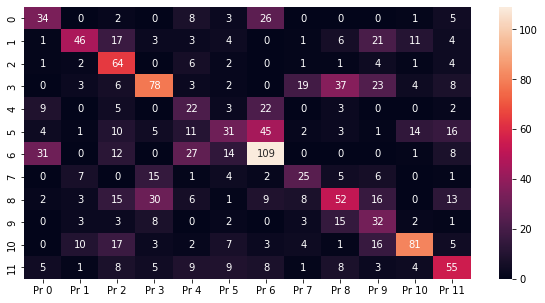

In [20]:
lab= list(range(0,12))
plab=["Pr "+str(s) for s in lab]
cm=confusion_matrix(y_test,y_pred,labels=lab)
df_cm = pd.DataFrame(cm, index = [i for i in lab],
                  columns = [i for i in plab])
plt.figure(figsize = (10,5))
sns.heatmap(df_cm, annot=True ,fmt='g')

<b> Few classes like 3 and 10 have higher accuracies </b>

In [23]:
# tuning SVM
C=[1, 10, 100, 1000]
gamma =[0.001, 0.0001]
kernel = ['linear','rbf']
sv = svm.SVC() #declare

param_grid = dict(C=C, gamma=gamma,kernel = kernel)    # define parameter grid based on these parameters
sv_grid = RandomizedSearchCV(sv,param_grid, scoring='accuracy',n_jobs=-1) # finding best parameters using gridsearch
sv_grid.fit(X_train_pca, y_train) # fit the model

#find best parameters
print(sv_grid.best_score_)
print(sv_grid.best_params_)

0.5287811184228245
{'kernel': 'rbf', 'gamma': 0.001, 'C': 1000}


In [127]:
# Fit SVM model  using first N pca components
model = svm.SVC(C=1000,gamma=0.001,kernel='rbf',random_state=1)
model.fit(X_train_pca, y_train)
y_pred = model.predict(X_test_pca)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.38      0.34      0.36        79
         1.0       0.66      0.60      0.63       117
         2.0       0.64      0.70      0.67        86
         3.0       0.59      0.65      0.62       183
         4.0       0.39      0.39      0.39        66
         5.0       0.42      0.41      0.42       143
         6.0       0.53      0.69      0.60       202
         7.0       0.68      0.23      0.34        66
         8.0       0.53      0.57      0.55       155
         9.0       0.43      0.29      0.34        69
        10.0       0.73      0.71      0.72       149
        11.0       0.47      0.44      0.45       116

    accuracy                           0.55      1431
   macro avg       0.54      0.50      0.51      1431
weighted avg       0.55      0.55      0.54      1431



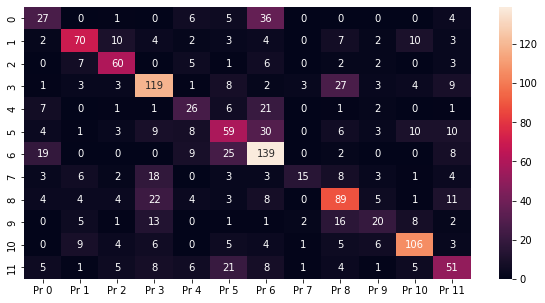

In [128]:
lab= list(range(0,12))
plab=["Pr "+str(s) for s in lab]
cm=confusion_matrix(y_test,y_pred,labels=lab)
df_cm = pd.DataFrame(cm, index = [i for i in lab],
                  columns = [i for i in plab])
plt.figure(figsize = (10,5))
sns.heatmap(df_cm, annot=True ,fmt='g')

<b> Accuracy improved to 55% using best parameters found using gridsearch </b>

<b> 2. Using neural networks to perform the same task </b>

In [27]:
Lambda = 1e-3
dropout = 0.2
lr = 1e-3
activation = 'relu'
output_nodes=12
opt = Adam(lr=lr)

In [29]:
xs_train.shape, xs_test.shape, y_train.shape, y_test.shape

((3336, 128, 128, 3), (1431, 128, 128, 3), (3336,), (1431,))

In [46]:
model = Sequential()
input_units = 1024
    
#1 hidden layer
model.add(Dense(units = input_units, 
                input_shape = (2700,), 
                kernel_regularizer = regularizers.l2(Lambda), # regularization
                kernel_initializer='he_normal' # added weight initializer
                )
          ) 


model.add(BatchNormalization()) # normalize before activation
model.add(Activation(activation)) #Activation
model.add(Dropout(dropout)) # added dropout

#2nd hidden layer
model.add(Dense(units = input_units, 
                kernel_regularizer = regularizers.l2(Lambda), # regularization
                kernel_initializer='he_normal' # added weight initializer
                )
          ) 


model.add(BatchNormalization()) # normalize before activation
model.add(Activation(activation)) #Activation
model.add(Dropout(dropout)) # added dropout

#3rd hidden layer
model.add(Dense(units = input_units, 
                kernel_regularizer = regularizers.l2(Lambda), # regularization
                kernel_initializer='he_normal' # added weight initializer
                )
          ) 


model.add(BatchNormalization()) # normalize before activation
model.add(Activation(activation)) #Activation
model.add(Dropout(dropout)) # added dropout

# output layer with softmax activation
model.add(Dense(output_nodes,activation='softmax', kernel_regularizer = regularizers.l2(Lambda)))
# Compile the model
model.compile(optimizer = opt,
              loss = 'sparse_categorical_crossentropy', # large dataset.. so using sparse loss
              metrics=['accuracy'])

model.fit(X_train_pca,y_train,epochs=10,validation_data=(X_test_pca,y_test),verbose= 1) 
train_score = model.evaluate(X_train_pca, y_train, verbose=0) 
print("Training set score:",train_score)
test_score = model.evaluate(X_test_pca, y_test, verbose=0) 
print("Testing set score:",test_score)

Epoch 1/10
105/105 [==============================] - 2s 9ms/step - loss: 10.4134 - accuracy: 0.2728 - val_loss: 7.7095 - val_accuracy: 0.3459
Epoch 2/10
105/105 [==============================] - 1s 7ms/step - loss: 5.6113 - accuracy: 0.5357 - val_loss: 5.1518 - val_accuracy: 0.4158
Epoch 3/10
105/105 [==============================] - 1s 7ms/step - loss: 3.9843 - accuracy: 0.6697 - val_loss: 4.5279 - val_accuracy: 0.4396
Epoch 4/10
105/105 [==============================] - 1s 7ms/step - loss: 3.3931 - accuracy: 0.7269 - val_loss: 4.1809 - val_accuracy: 0.4514
Epoch 5/10
105/105 [==============================] - 1s 9ms/step - loss: 2.8981 - accuracy: 0.7899 - val_loss: 3.9390 - val_accuracy: 0.4668
Epoch 6/10
105/105 [==============================] - 1s 9ms/step - loss: 2.7823 - accuracy: 0.7920 - val_loss: 3.8869 - val_accuracy: 0.4717
Epoch 7/10
105/105 [==============================] - 1s 11ms/step - loss: 2.4736 - accuracy: 0.8423 - val_loss: 3.9187 - val_accuracy: 0.4500
Epoc

In [47]:
model = Sequential()
input_units = 1024
    
#1 hidden layer
model.add(Dense(units = input_units, 
                input_shape = (2700,), 
                kernel_regularizer = regularizers.l2(Lambda), # regularization
                kernel_initializer='he_normal' # added weight initializer
                )
          ) 


model.add(BatchNormalization()) # normalize before activation
model.add(Activation(activation)) #Activation
model.add(Dropout(dropout)) # added dropout

#2nd hidden layer
model.add(Dense(units = 512, 
                kernel_regularizer = regularizers.l2(Lambda), # regularization
                kernel_initializer='he_normal' # added weight initializer
                )
          ) 


model.add(BatchNormalization()) # normalize before activation
model.add(Activation(activation)) #Activation
model.add(Dropout(dropout)) # added dropout

#3rd hidden layer
model.add(Dense(units = 256, 
                kernel_regularizer = regularizers.l2(Lambda), # regularization
                kernel_initializer='he_normal' # added weight initializer
                )
          ) 


model.add(BatchNormalization()) # normalize before activation
model.add(Activation(activation)) #Activation
model.add(Dropout(dropout)) # added dropout

# output layer with softmax activation
model.add(Dense(output_nodes,activation='softmax', kernel_regularizer = regularizers.l2(Lambda)))
# Compile the model
model.compile(optimizer = opt,
              loss = 'sparse_categorical_crossentropy', # large dataset.. so using sparse loss
              metrics=['accuracy'])

model.fit(X_train_pca,y_train,epochs=10,validation_data=(X_test_pca,y_test),verbose= 1) 
train_score = model.evaluate(X_train_pca, y_train, verbose=0) 
print("Training set score:",train_score)
test_score = model.evaluate(X_test_pca, y_test, verbose=0) 
print("Testing set score:",test_score)

Epoch 1/10
105/105 [==============================] - 2s 10ms/step - loss: 6.9091 - accuracy: 0.2953 - val_loss: 5.3771 - val_accuracy: 0.3368
Epoch 2/10
105/105 [==============================] - 1s 8ms/step - loss: 3.9722 - accuracy: 0.5621 - val_loss: 3.9877 - val_accuracy: 0.4626
Epoch 3/10
105/105 [==============================] - 1s 8ms/step - loss: 3.1296 - accuracy: 0.6820 - val_loss: 3.6838 - val_accuracy: 0.4724
Epoch 4/10
105/105 [==============================] - 1s 8ms/step - loss: 2.6613 - accuracy: 0.7602 - val_loss: 3.4817 - val_accuracy: 0.4815
Epoch 5/10
105/105 [==============================] - 1s 8ms/step - loss: 2.3544 - accuracy: 0.8165 - val_loss: 3.4194 - val_accuracy: 0.4759
Epoch 6/10
105/105 [==============================] - 1s 7ms/step - loss: 2.2328 - accuracy: 0.8255 - val_loss: 3.4236 - val_accuracy: 0.4801
Epoch 7/10
105/105 [==============================] - 1s 7ms/step - loss: 2.0154 - accuracy: 0.8630 - val_loss: 3.4261 - val_accuracy: 0.4682
Epoch

In [48]:
model = Sequential()
input_units = 1024
    
#1 hidden layer
model.add(Dense(units = input_units, 
                input_shape = (2700,), 
                kernel_regularizer = regularizers.l2(Lambda), # regularization
                kernel_initializer='he_normal' # added weight initializer
                )
          ) 


model.add(BatchNormalization()) # normalize before activation
model.add(Activation(activation)) #Activation
model.add(Dropout(dropout)) # added dropout

#2nd hidden layer
model.add(Dense(units = 512, 
                kernel_regularizer = regularizers.l2(Lambda), # regularization
                kernel_initializer='he_normal' # added weight initializer
                )
          ) 


model.add(BatchNormalization()) # normalize before activation
model.add(Activation(activation)) #Activation
model.add(Dropout(dropout)) # added dropout

#3rd hidden layer
model.add(Dense(units = 256, 
                kernel_regularizer = regularizers.l2(Lambda), # regularization
                kernel_initializer='he_normal' # added weight initializer
                )
          ) 


model.add(BatchNormalization()) # normalize before activation
model.add(Activation(activation)) #Activation
model.add(Dropout(dropout)) # added dropout

#4th hidden layer
model.add(Dense(units = 128, 
                kernel_regularizer = regularizers.l2(Lambda), # regularization
                kernel_initializer='he_normal' # added weight initializer
                )
          ) 


model.add(BatchNormalization()) # normalize before activation
model.add(Activation(activation)) #Activation
model.add(Dropout(dropout)) # added dropout

# output layer with softmax activation
model.add(Dense(output_nodes,activation='softmax', kernel_regularizer = regularizers.l2(Lambda)))
# Compile the model
model.compile(optimizer = opt,
              loss = 'sparse_categorical_crossentropy', # large dataset.. so using sparse loss
              metrics=['accuracy'])

model.fit(X_train_pca,y_train,epochs=10,validation_data=(X_test_pca,y_test),verbose= 1) 
train_score = model.evaluate(X_train_pca, y_train, verbose=0) 
print("Training set score:",train_score)
test_score = model.evaluate(X_test_pca, y_test, verbose=0) 
print("Testing set score:",test_score)

Epoch 1/10
105/105 [==============================] - 3s 10ms/step - loss: 7.2042 - accuracy: 0.2476 - val_loss: 5.6039 - val_accuracy: 0.3166
Epoch 2/10
105/105 [==============================] - 1s 7ms/step - loss: 4.2879 - accuracy: 0.4961 - val_loss: 4.0104 - val_accuracy: 0.4242
Epoch 3/10
105/105 [==============================] - 1s 7ms/step - loss: 3.3351 - accuracy: 0.5920 - val_loss: 3.5959 - val_accuracy: 0.4710
Epoch 4/10
105/105 [==============================] - 1s 7ms/step - loss: 2.9230 - accuracy: 0.6649 - val_loss: 3.4574 - val_accuracy: 0.4682
Epoch 5/10
105/105 [==============================] - 1s 7ms/step - loss: 2.5912 - accuracy: 0.7275 - val_loss: 3.4507 - val_accuracy: 0.4493
Epoch 6/10
105/105 [==============================] - 1s 8ms/step - loss: 2.4345 - accuracy: 0.7572 - val_loss: 3.4615 - val_accuracy: 0.4542
Epoch 7/10
105/105 [==============================] - 1s 7ms/step - loss: 2.3093 - accuracy: 0.7872 - val_loss: 3.2572 - val_accuracy: 0.4934
Epoch

In [51]:
# Creates a model with 3 layers based on trial and error above
def cr_model(Lambda,dropout=0.2,lr=0.01,activation = 'relu',verb=True):
  
    #initialize
      
    output_nodes = 12
    
    # Create an Adam optimizer with the given learning rate
    opt = Adam(lr=lr)
  
    # Create FNN model  
    model = Sequential()
    
    #1 hidden layer
    model.add(Dense(units = 1024, 
                    input_shape = (2700,), 
                    kernel_regularizer = regularizers.l2(Lambda), # regularization
                    kernel_initializer='he_normal' # added weight initializer
                   )
             ) 
    model.add(BatchNormalization()) # normalize before activation
    model.add(Activation(activation)) #Activation
    model.add(Dropout(dropout)) # added dropout
    
    #2nd  hidden layer
    model.add(Dense(units = 512, 
                   kernel_regularizer = regularizers.l2(Lambda), # regularization
                   kernel_initializer='he_normal'  # added weight initializer
                   )
             ) 
    
    model.add(BatchNormalization()) # normalize before activation
    model.add(Activation(activation)) #Activation
    model.add(Dropout(dropout)) # added dropout

   #3rd  hidden layer
    model.add(Dense(units = 256, 
                   kernel_regularizer = regularizers.l2(Lambda), # regularization
                   kernel_initializer='he_normal'  # added weight initializer
                   )
             ) 
    
    model.add(BatchNormalization()) # normalize before activation
    model.add(Activation(activation)) #Activation
    model.add(Dropout(dropout)) # added dropout

    # output layer with softmax activation
    model.add(Dense(output_nodes,activation='softmax', kernel_regularizer = regularizers.l2(Lambda)))
    # Compile the model
    model.compile(optimizer = opt,
                  loss = 'sparse_categorical_crossentropy', # large dataset.. so using sparse loss
                  metrics=['accuracy'])
    return model

In [52]:
# figure out best lr and Lamda
import math
model = cr_model(Lambda,dropout,lr,activation)
for k in range(1,10):
    lr = math.pow(10, np.random.uniform(-7.0, 1.0))
    Lambda = math.pow(10, np.random.uniform(-7,-2))
    model.fit(X_train_pca,y_train,epochs=10,validation_data=(X_test_pca,y_test),verbose= 1) 
    score = model.evaluate(X_train_pca,y_train,verbose=0)
    print("Try {0}/{1}: Best_val_acc: {2}, lr: {3}, Lambda: {4}\n".format(k, 100, score[1], lr, Lambda))

Epoch 1/10
105/105 [==============================] - 3s 11ms/step - loss: 5.8194 - accuracy: 0.2557 - val_loss: 5.3158 - val_accuracy: 0.3655
Epoch 2/10
105/105 [==============================] - 1s 9ms/step - loss: 4.3961 - accuracy: 0.6289 - val_loss: 4.7162 - val_accuracy: 0.4493
Epoch 3/10
105/105 [==============================] - 1s 9ms/step - loss: 3.5253 - accuracy: 0.8103 - val_loss: 4.5233 - val_accuracy: 0.4361
Epoch 4/10
105/105 [==============================] - 1s 8ms/step - loss: 3.0345 - accuracy: 0.8675 - val_loss: 4.3936 - val_accuracy: 0.4396
Epoch 5/10
105/105 [==============================] - 1s 7ms/step - loss: 2.7169 - accuracy: 0.8921 - val_loss: 4.2548 - val_accuracy: 0.4430
Epoch 6/10
105/105 [==============================] - 1s 7ms/step - loss: 2.5448 - accuracy: 0.8933 - val_loss: 4.2884 - val_accuracy: 0.4312
Epoch 7/10
105/105 [==============================] - 1s 7ms/step - loss: 2.3469 - accuracy: 0.9107 - val_loss: 4.0980 - val_accuracy: 0.4570
Epoch

In [118]:
# based on values found in above step
Lambda = 1e-6
dropout = 0.2
lr = 1e-4
activation = 'relu'
output_nodes=12
opt = Adam(lr=lr)

model = cr_model(Lambda,dropout,lr,activation)
model.fit(X_train_pca,y_train,epochs=10,validation_data=(X_test_pca,y_test),verbose= 1) 
train_score = model.evaluate(X_train_pca, y_train, verbose=0) 
print("Training set score:",train_score)
test_score = model.evaluate(X_test_pca, y_test, verbose=0) 
print("Testing set score:",test_score)

Epoch 1/10
105/105 [==============================] - 2s 9ms/step - loss: 2.7871 - accuracy: 0.1151 - val_loss: 2.3594 - val_accuracy: 0.1824
Epoch 2/10
105/105 [==============================] - 1s 6ms/step - loss: 2.2892 - accuracy: 0.2269 - val_loss: 2.2004 - val_accuracy: 0.2662
Epoch 3/10
105/105 [==============================] - 1s 6ms/step - loss: 1.9684 - accuracy: 0.3417 - val_loss: 2.0686 - val_accuracy: 0.3061
Epoch 4/10
105/105 [==============================] - 1s 7ms/step - loss: 1.7158 - accuracy: 0.4469 - val_loss: 1.9610 - val_accuracy: 0.3424
Epoch 5/10
105/105 [==============================] - 1s 6ms/step - loss: 1.4747 - accuracy: 0.5423 - val_loss: 1.8774 - val_accuracy: 0.3606
Epoch 6/10
105/105 [==============================] - 1s 7ms/step - loss: 1.2798 - accuracy: 0.6061 - val_loss: 1.8102 - val_accuracy: 0.3809
Epoch 7/10
105/105 [==============================] - 1s 6ms/step - loss: 1.0808 - accuracy: 0.6888 - val_loss: 1.7547 - val_accuracy: 0.3948
Epoch 

In [124]:
y_pred = model.predict(X_test_pca)
y_pred.shape

(1431, 12)

In [125]:
y_pred_new = np.zeros(y_pred.shape[0])
for i in range(y_pred.shape[0]):
  y_pred_new[i]= np.argmax(y_pred[i])

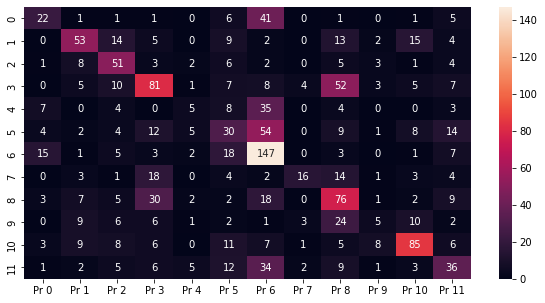

In [126]:
lab= list(range(0,12))
plab=["Pr "+str(s) for s in lab]
cm=confusion_matrix(y_test,y_pred_new,labels=lab)
df_cm = pd.DataFrame(cm, index = [i for i in lab],
                  columns = [i for i in plab])
plt.figure(figsize = (10,5))
sns.heatmap(df_cm, annot=True ,fmt='g')

In [69]:
model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_78 (Dense)            (None, 1024)              2765824   
                                                                 
 batch_normalization_52 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                                 
 activation_50 (Activation)  (None, 1024)              0         
                                                                 
 dropout_52 (Dropout)        (None, 1024)              0         
                                                                 
 dense_79 (Dense)            (None, 512)               524800    
                                                                 
 batch_normalization_53 (Bat  (None, 512)              2048      
 chNormalization)                                    

<b> Prediction accuracy using ANN on validation set is at 43% with higher accuracies for 'Common Chickweed' , 'Small-flowered Cranesbill' etc. and has around 3.5 million trainable params

<b> 3. Using CNN to solve this problem </b>

In [89]:
from tensorflow.keras.layers import Conv2D,MaxPool2D,Flatten

def cnn_model(Lambda,dropout=0.2,lr=0.01,activation = 'relu',verb=True):
  
  output_nodes = 12
  # Create an Adam optimizer with the given learning rate
  opt = Adam(lr=lr)
  batch_size = None
  model = Sequential()

  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                  activation ='relu', batch_input_shape =(batch_size,128, 128, 3)))


  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPool2D(pool_size=(2,2))) #pooling
  model.add(Dropout(dropout))


  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                  activation ='relu'))
  model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(dropout))

  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(dropout))


  model.add(Flatten())
  # output layer with softmax activation
  model.add(Dense(output_nodes,activation='softmax', kernel_regularizer = regularizers.l2(Lambda)))
  # Compile the model
  model.compile(optimizer = opt,
                loss = 'sparse_categorical_crossentropy', # large dataset.. so using sparse loss
                metrics=['accuracy'])
  return model

In [78]:
xs_train.shape, xs_test.shape,y_train.shape, y_test.shape

((3336, 128, 128, 3), (1431, 128, 128, 3), (3336,), (1431,))

In [97]:
Lambda = 1e-3
dropout = 0.2
lr = 1e-3
activation = 'relu'
output_nodes=12

model = cnn_model(Lambda,dropout,lr,activation)
model.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 128, 128, 32)      2432      
                                                                 
 conv2d_37 (Conv2D)          (None, 128, 128, 32)      25632     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 dropout_73 (Dropout)        (None, 64, 64, 32)        0         
                                                                 
 conv2d_38 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 conv2d_39 (Conv2D)          (None, 64, 64, 64)        36928     
                                                     

In [98]:
model.fit(xs_train,y_train,epochs=10,validation_data=(xs_test,y_test),verbose= 1) 
train_score = model.evaluate(xs_train, y_train, verbose=0) 

Epoch 1/10
105/105 [==============================] - 5s 36ms/step - loss: 2.4589 - accuracy: 0.1358 - val_loss: 2.4276 - val_accuracy: 0.1279
Epoch 2/10
105/105 [==============================] - 3s 33ms/step - loss: 2.4308 - accuracy: 0.1430 - val_loss: 2.4256 - val_accuracy: 0.1279
Epoch 3/10
105/105 [==============================] - 3s 33ms/step - loss: 2.0470 - accuracy: 0.3013 - val_loss: 1.8004 - val_accuracy: 0.4179
Epoch 4/10
105/105 [==============================] - 3s 33ms/step - loss: 1.5430 - accuracy: 0.4907 - val_loss: 1.4598 - val_accuracy: 0.4976
Epoch 5/10
105/105 [==============================] - 3s 33ms/step - loss: 1.2738 - accuracy: 0.5821 - val_loss: 1.2847 - val_accuracy: 0.5863
Epoch 6/10
105/105 [==============================] - 3s 33ms/step - loss: 1.0360 - accuracy: 0.6763 - val_loss: 1.1455 - val_accuracy: 0.6534
Epoch 7/10
105/105 [==============================] - 4s 34ms/step - loss: 0.9423 - accuracy: 0.7032 - val_loss: 1.1970 - val_accuracy: 0.6597

In [99]:
print(train_score)

[0.45501115918159485, 0.8845923542976379]


In [100]:
test_score = model.evaluate(xs_test, y_test, verbose=0) 
print("Testing set score:",test_score)

Testing set score: [1.1766668558120728, 0.6820405125617981]


<b> Quite a good improvement in accuracy of validation set with very less parameters to train compared to regular ANN</b>

In [106]:
y_pred = model.predict(xs_test)
y_pred.shape

(1431, 12)

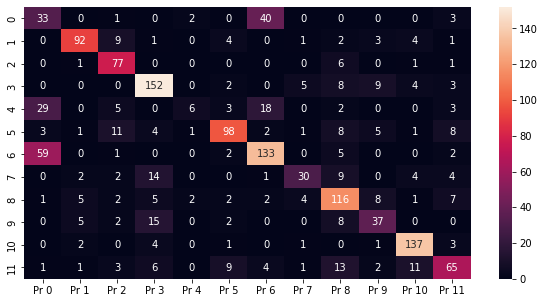

In [103]:
y_pred_new = np.zeros(y_pred.shape[0])
for i in range(y_pred.shape[0]):
  y_pred_new[i]= np.argmax(y_pred[i])

lab= list(range(0,12))
plab=["Pr "+str(s) for s in lab]
cm=confusion_matrix(y_test,y_pred_new,labels=lab)
df_cm = pd.DataFrame(cm, index = [i for i in lab],
                  columns = [i for i in plab])
plt.figure(figsize = (10,5))
sns.heatmap(df_cm, annot=True ,fmt='g')

<b> Improvement seen across most labels </b>

In [114]:
data_path = '/content/drive/MyDrive/Seedling - Prediction/'
img = []
# os.chdir(data_path)
for data in listdir(data_path):
  im_data = get_img(data_path+'/'+ data)
  img.append(im_data)
im_pred = np.array(img).astype('float32')/255
print(im_pred.shape)

Reading... /content/drive/MyDrive/Seedling - Prediction//Predict.png
Shape of  /content/drive/MyDrive/Seedling - Prediction//Predict.png :  (128, 128, 3)
(1, 128, 128, 3)


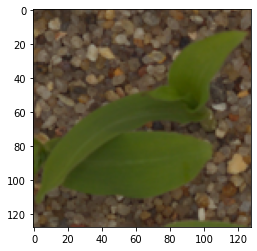

In [110]:
plt.imshow(im_data) # check the image to be predicted

In [117]:
y_pred_1 = model.predict(x)
print(np.argmax(y_pred_1))
print(y_pred_1)

7
[[2.8177187e-13 3.0156318e-07 1.6110304e-06 9.5225323e-04 4.5845181e-09
  5.5184842e-07 1.1341658e-09 9.9586749e-01 2.5878693e-03 5.8369280e-04
  2.3614848e-06 3.9075321e-06]]


<b> The Predict.png is predicted to be 'Maize' </b>